# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

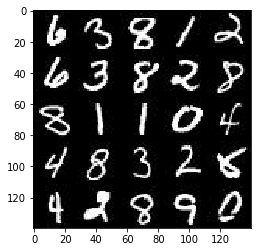

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

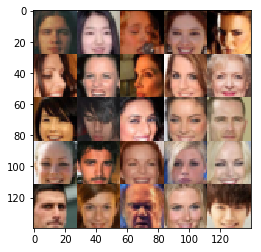

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_images = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name='inputs_images')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_images,inputs_z, learn_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/mrmad/miniconda3/envs/dlnd/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/mrmad/miniconda3/envs/dlnd/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/mrmad/miniconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/mrmad/miniconda3/envs/dlnd/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/mrmad/miniconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/mrmad/mi

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Implementing DCGAN model

    alpha = 0.20
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn1 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn1, bn1)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn2, bn2)
        
        flat = tf.reshape(relu3, (-1,4*4*256))
        
        logits= tf.layers.dense(flat,1)
        out= tf.sigmoid(logits)
    
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse_state = not is_train
    alpha = 0.10
    with tf.variable_scope('generator',reuse=reuse_state): 
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4,strides = 1, padding= 'valid' )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same')    
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list= g_vars)
        d_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list= d_vars)
    
        return d_opt_train, g_opt_train

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # TODO: Build Model
    
    losses = []
    steps = 0
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z , learning_rate_pl = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate_pl, beta1)
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count): 
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                
                
                
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,n_images,input_z,image_channels,data_image_mode)
                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3317... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 2.9890... Generator Loss: 1.8109
Epoch 1/2... Discriminator Loss: 1.8875... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.9358... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 2.0486... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.8014... Generator Loss: 0.4393
Epoch 1/2... Discriminator Loss: 1.7909... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.7423


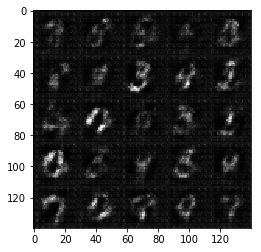

Epoch 1/2... Discriminator Loss: 1.6859... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 1.5943... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 1.0278
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 1.0138
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 1.1365


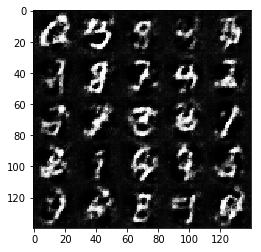

Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.5941... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.5508... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 1.4770... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.6003... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 1.0994


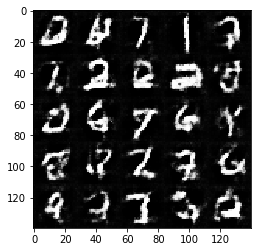

Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.5278... Generator Loss: 1.0955
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.9663
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 1.0585
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.9220


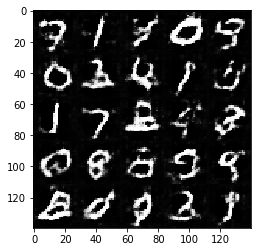

Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 0.9341
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.4288... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 0.9040
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.8988


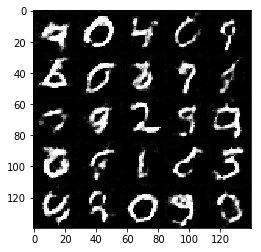

Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 1.0364
Epoch 1/2... Discriminator Loss: 1.4971... Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 1.7987... Generator Loss: 0.2925
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 0.4044
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.3775


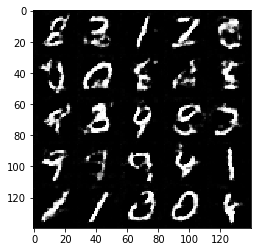

Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 1.7889... Generator Loss: 0.2926
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.5981
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.7897... Generator Loss: 1.3847
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.8520


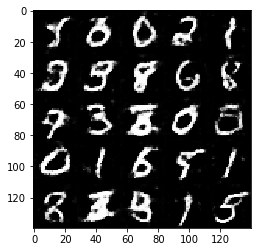

Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.4381... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.8234... Generator Loss: 1.2793
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.7320


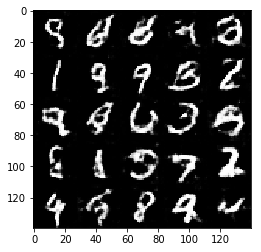

Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 1.0486
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 1.5941... Generator Loss: 0.3934
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.5032
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.4513
Epoch 1/2... Discriminator Loss: 1.4805... Generator Loss: 0.4927
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.6631... Generator Loss: 0.3393


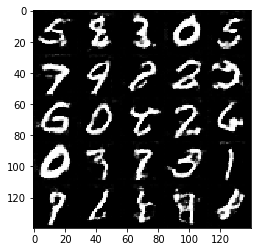

Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.5555
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 0.5681
Epoch 2/2... Discriminator Loss: 1.6506... Generator Loss: 0.3653
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.4631... Generator Loss: 0.6560
Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.5603


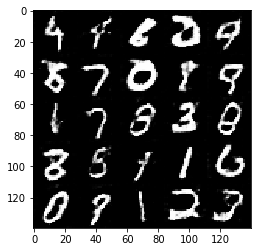

Epoch 2/2... Discriminator Loss: 1.4622... Generator Loss: 0.4979
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.4901
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.5226
Epoch 2/2... Discriminator Loss: 2.1793... Generator Loss: 0.1808
Epoch 2/2... Discriminator Loss: 1.5901... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.8510
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.9139


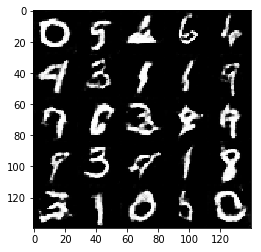

Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 1.5350... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 1.5450... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.6466
Epoch 2/2... Discriminator Loss: 1.7626... Generator Loss: 0.3017
Epoch 2/2... Discriminator Loss: 1.5277... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.6322


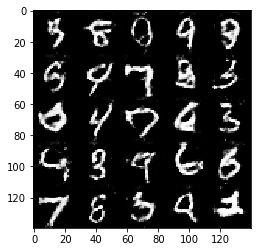

Epoch 2/2... Discriminator Loss: 1.8384... Generator Loss: 0.2768
Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 0.5516
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 1.6943... Generator Loss: 0.3247
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 1.6923... Generator Loss: 0.3366
Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 0.4640
Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 0.3965
Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.5354


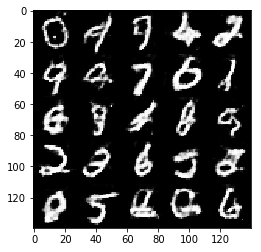

Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.5433... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 1.5447... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.4413... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.6976... Generator Loss: 1.8604
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.6632


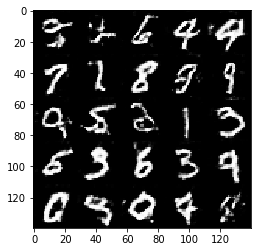

Epoch 2/2... Discriminator Loss: 1.5620... Generator Loss: 0.4021
Epoch 2/2... Discriminator Loss: 1.7013... Generator Loss: 0.3336
Epoch 2/2... Discriminator Loss: 1.5550... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 2.0151... Generator Loss: 0.2200
Epoch 2/2... Discriminator Loss: 1.5656... Generator Loss: 0.4160
Epoch 2/2... Discriminator Loss: 1.5790... Generator Loss: 0.3937
Epoch 2/2... Discriminator Loss: 1.6439... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 1.7167... Generator Loss: 0.3425
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7056


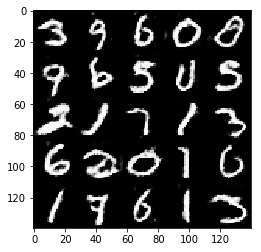

Epoch 2/2... Discriminator Loss: 2.1157... Generator Loss: 1.6821
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 0.4610
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 1.0930
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.9500


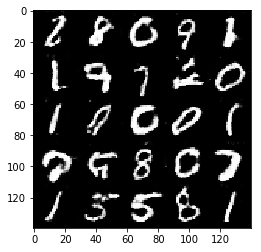

Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.6193
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.5781... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.9166
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.5982
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.3901


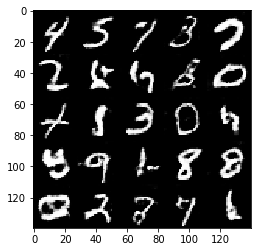

Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.7586... Generator Loss: 0.3266
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.4105
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.5099... Generator Loss: 0.4728
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.6033... Generator Loss: 0.4125
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.8457... Generator Loss: 0.3001


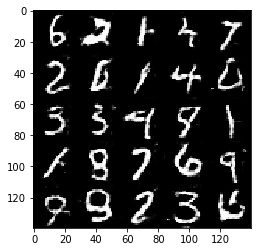

Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 1.1445
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.5727
Epoch 2/2... Discriminator Loss: 1.6478... Generator Loss: 0.3835
Epoch 2/2... Discriminator Loss: 1.8032... Generator Loss: 0.2880
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.6030... Generator Loss: 0.3928


In [12]:
batch_size = 64
z_dim = 130
learning_rate = 0.0005
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5784... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 3.8402... Generator Loss: 0.0740
Epoch 1/1... Discriminator Loss: 2.7333... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 1.8112... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 2.4682... Generator Loss: 0.2974
Epoch 1/1... Discriminator Loss: 1.7953... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.7634


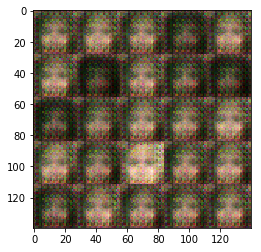

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.8505... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.6565


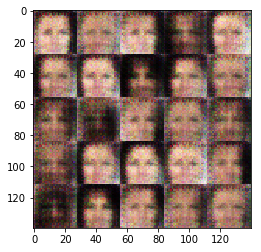

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7417


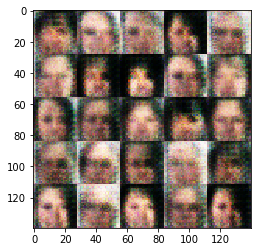

Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7293


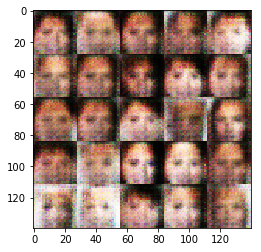

Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6810


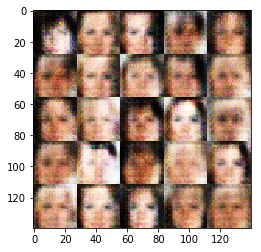

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7326


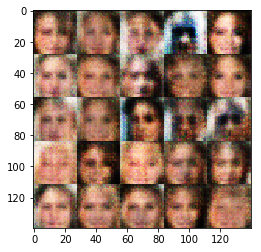

Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6722


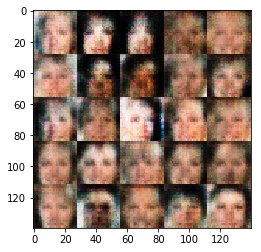

Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7748


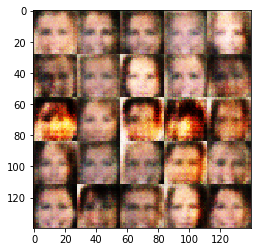

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7729


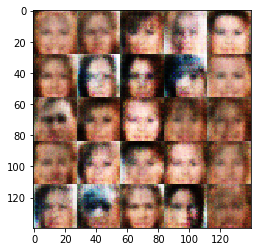

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6639


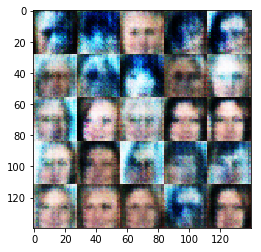

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7185


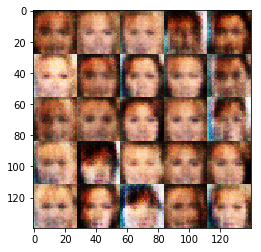

Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7524


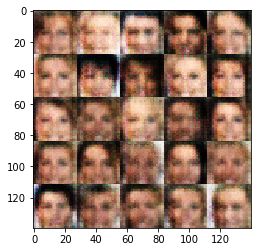

Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7363


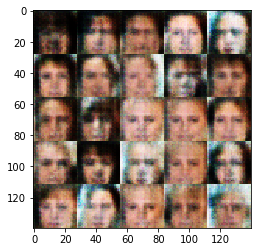

Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7416


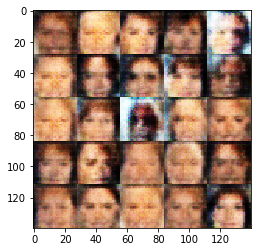

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6777


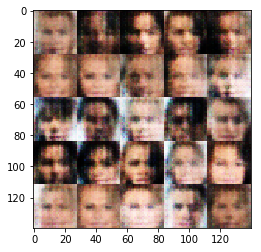

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7812


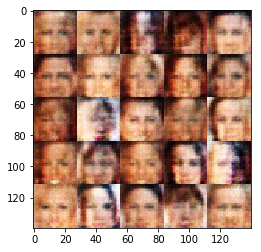

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7323


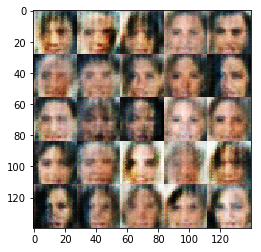

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7547


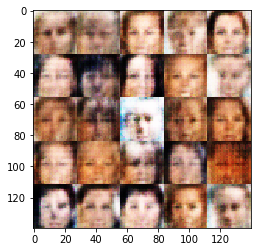

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6623


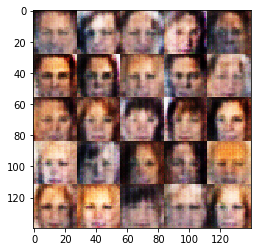

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8096


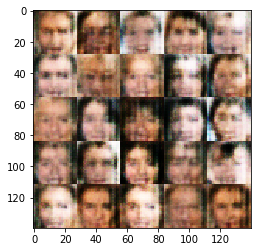

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7504


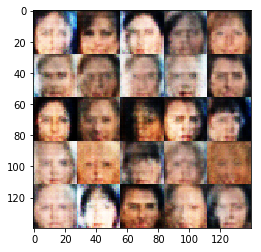

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7355


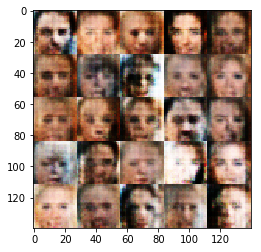

Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7529


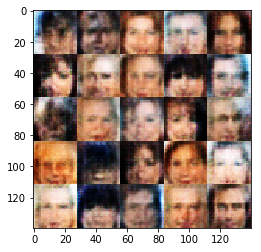

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7649


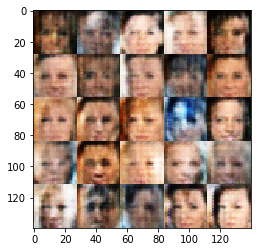

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8345


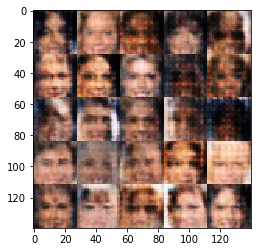

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8519


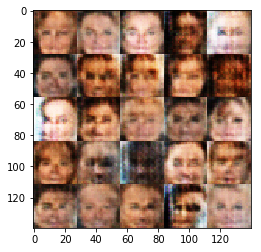

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7648


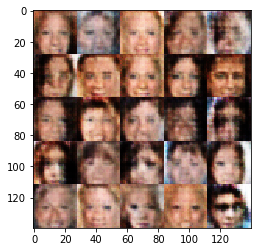

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8321


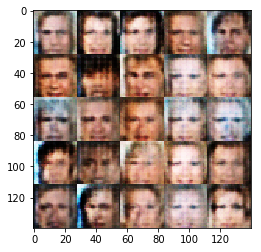

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6753


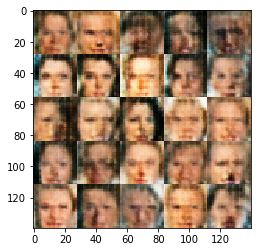

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7443


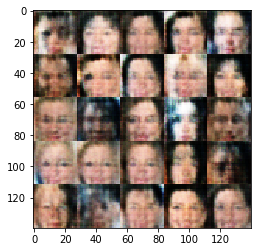

Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8360


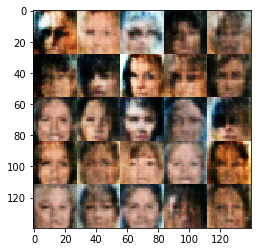

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7436


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.